In [2]:
import mlflow
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
%matplotlib inline

In [3]:
# Set the tracking URI to the directory containing the mlruns folder
mlflow.set_tracking_uri("../../../mlruns")

# Odd and Even

We will use pGD to learn the minima of the CIB for various values of $\gamma$ and `uncertainty_y`.

## Load and pre-process the data

In [4]:
# Retrieve all runs from the experiment of interest
experiment = mlflow.get_experiment_by_name("Odd and Even")
experiment_id = experiment.experiment_id
print(experiment_id)

692411143533995847


In [5]:
try:
    runs_df = pd.read_csv('odd_and_even_runs.csv')
except FileNotFoundError:
    # Extract df from mlflow directly
    runs_df = mlflow.search_runs(experiment_ids=experiment_id, max_results=100000)
    # Export the DataFrame to a CSV file
    runs_df.to_csv('odd_and_even_runs.csv', index=False)

print(len(runs_df))
print(runs_df.columns)

144
Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.converged', 'metrics.diff_loss', 'metrics.HY',
       'metrics.Expected optimal HTcondX', 'metrics.diff_q',
       'metrics.VI of T and T_', 'metrics.HTcondX', 'metrics.penalty',
       'metrics.Expected optimal HT', 'metrics.Expected optimal CIB loss',
       'metrics.Final CIB loss', 'metrics.HcYdoT', 'metrics.HT',
       'metrics.CIB loss', 'metrics.Expected optimal HcYdoT',
       'params.end_lr_factor', 'params.Expected optimal q', 'params.max iter',
       'params.beta', 'params.Learned q', 'params.eps', 'params.uncertainty_y',
       'params.lr', 'params.gamma', 'tags.mlflow.source.git.commit',
       'tags.mlflow.source.name', 'tags.mlflow.user',
       'tags.mlflow.source.type', 'tags.mlflow.runName', 'tags.optimizer',
       'tags.loss'],
      dtype='object')


In [6]:
# Add duration metric
runs_df['metrics.duration']=(pd.to_datetime(runs_df['end_time'], format='ISO8601') - pd.to_datetime(runs_df['start_time'], format='ISO8601')).dt.total_seconds()

In [7]:
# Only need some columns
runs = runs_df[[
      'metrics.duration',
      'params.uncertainty_y',
      'params.gamma',
      'params.beta',
      'params.lr',
      'metrics.VI of T and T_',
      'metrics.Final CIB loss',
      'metrics.HT',
      'metrics.HTcondX',
      'metrics.HY',
      'metrics.HcYdoT',
      'metrics.converged',
      'params.Learned q',
      'tags.optimizer',
      'tags.loss'
]]

In [8]:
# List of columns that should be float
float_columns = ['params.uncertainty_y', 'params.gamma', 'params.beta', 'params.lr'] 
runs.loc[:, float_columns] = runs[float_columns].apply(pd.to_numeric, errors='raise')

# Remove prefixes
runs.columns = runs.columns.str.split('.').str[1]

# Add MI, Ic columns
runs.loc[:, ['MI_XT']] = runs['HT'] - runs['HTcondX']
runs.loc[:, ['IcYdoT']] = runs['HY'] - runs['HcYdoT']
runs.head()

,duration,uncertainty_y,gamma,beta,lr,VI of T and T_,Final CIB loss,HT,HTcondX,HY,HcYdoT,converged,Learned q,optimizer,loss,MI_XT,IcYdoT
0,0.582,0.5,1.0,inf,1.0,1.801787,1.192093e-07,0.903733,0.495085,1.0,1.0,1.0,"tensor([[0.0300, 0.2900, 0.9700, 0.1000, 0.210...",pGD,wCIB,0.408648,-1.192093e-07
1,0.743,0.5,1.0,inf,1.0,1.941721,0.000000e+00,0.988407,0.683059,1.0,1.0,1.0,"tensor([[0.9600, 0.5300, 0.0700, 0.7300, 0.530...",pGD,wCIB,0.305347,0.000000e+00
2,0.584,0.5,1.0,inf,0.1,1.767229,1.192093e-07,0.886754,0.688035,1.0,1.0,1.0,"tensor([[0.4600, 0.6600, 0.1500, 0.2300, 0.020...",pGD,wCIB,0.198719,-1.192093e-07
3,0.583,0.5,1.0,inf,0.1,1.880694,1.192093e-07,0.916533,0.605807,1.0,1.0,1.0,"tensor([[1.0000, 0.3600, 0.7900, 0.9000, 0.290...",pGD,wCIB,0.310726,-1.192093e-07
4,4.203,0.5,0.8,4.0,1.0,1.950778,1.907349e-07,0.979827,0.979827,1.0,1.0,1.0,"tensor([[0.5800, 0.5800, 0.5800, 0.5800, 0.580...",pGD,wCIB,0.000000,-2.384186e-07


In [9]:
min_losses = runs.groupby(['gamma', 'uncertainty_y'], as_index=False)['Final CIB loss'].min()

# Merge the original DataFrame with the minimum losses DataFrame
df_merged = pd.merge(runs, min_losses, on=['gamma', 'uncertainty_y', 'Final CIB loss'])

# Drop duplicates to keep only one row per gamma value
best_runs = df_merged.drop_duplicates(subset=['gamma', 'uncertainty_y'])
#best_runs

## Parallel plots

In [10]:
columns_to_plot = ['uncertainty_y', 'gamma', 'IcYdoT', 'MI_XT', 'VI of T and T_',]

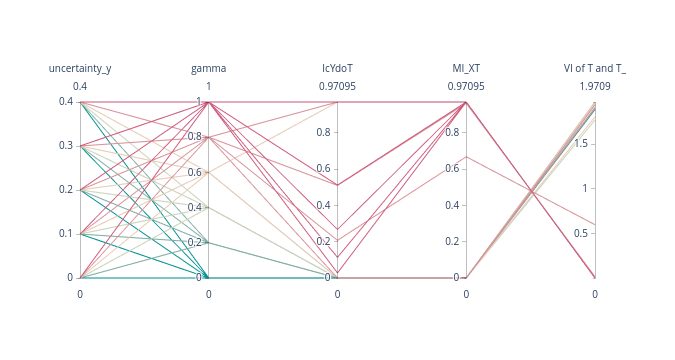

In [17]:
#conditions = (best_runs['converged'] == 1.0) & (best_runs['uncertainty_y'] < 0.5)
conditions = (best_runs['uncertainty_y'] < 0.5)
filtered_runs = best_runs[conditions]

dimensions = [{'label': col, 'values': filtered_runs[col]} for col in columns_to_plot]
fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            #colorbar=dict(title_text='gamma', tickvals=np.arange(0,1.1,0.2)),
            color=filtered_runs['gamma'], colorscale='TealRose', showscale=False), 
        dimensions=dimensions,
        unselected=dict(line=dict(color='gray', opacity=0.08))
    )
)
# Show the plot
fig.show()

In [12]:
pio.write_image(fig, 'parallel_plot_odd_and_even.pdf', format='pdf', scale=1, width=400, height=300)
pio.write_html(fig, file='parallel_plot_odd_and_even.html', auto_open=False)

Note that, for each $r_Y$, the expected order of the $I_c(Y\mid \mathit{do}(T))$ is respected. Namely, for $\gamma_1 > \gamma_2$, one has that the causal information gain for the encoder learned when $\gamma = \gamma_1$ is larger or equal to that of the encoder learned when $\gamma = \gamma_2$.

#### Case `uncertainty_y=0.2`

In [13]:
conditions = (best_runs['uncertainty_y'] == 0.2)
filtered_runs = best_runs[conditions]

dimensions = [
    {'label': 'gamma', 'values': filtered_runs['gamma']},
    {'label': 'IcYdoT', 'values': filtered_runs['IcYdoT'], 'range': [0, filtered_runs['IcYdoT'].max()]},
    {'label': 'MI_XT', 'values': filtered_runs['MI_XT'], 'range': [0, best_runs['MI_XT'].max()]},
    {'label': 'VI of T and T_', 'values': filtered_runs['VI of T and T_'], 'range': [best_runs['VI of T and T_'].min(), best_runs['VI of T and T_'].max()]},
]
fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            #colorbar=dict(title_text='gamma', tickvals=np.arange(0,1.1,0.2)),
            color=filtered_runs['gamma'], colorscale='TealRose', showscale=False), 
        dimensions=dimensions,
        unselected=dict(line=dict(color='gray', opacity=0.08))
    )
)
# Show the plot
fig.show()

In [14]:
pio.write_image(fig, 'parallel_plot_odd_and_even_uy02.pdf', format='pdf', scale=1, width=400, height=300)

## Extra: when uncertainty is 0.5

When `uncertainty_y=0.5`, controlling the parity of $X$ gives no control over $Y$, so that the CIB loss reduces to $(1-\gamma) I(X; Y)$.
Hence we expect the learned representations to simply fully compress $X$ when $\gamma \ne 1$.
As we see below, that is exactly what happens.

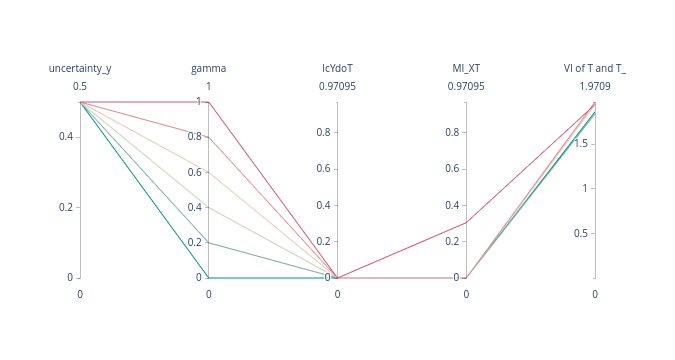

In [21]:
#conditions = (best_runs['converged']==1.0) & (best_runs['uncertainty_y']==0.5)
conditions = (best_runs['uncertainty_y']==0.5)
filtered_runs_random = best_runs[conditions]
dimensions = [
    {'label': 'uncertainty_y', 'values': filtered_runs_random['uncertainty_y'], 'range': [0, 0.5]},
    {'label': 'gamma', 'values': filtered_runs_random['gamma']},
    {'label': 'IcYdoT', 'values': filtered_runs_random['IcYdoT'], 'range': [0, best_runs['IcYdoT'].max()]},
    {'label': 'MI_XT', 'values': filtered_runs_random['MI_XT'], 'range': [0, best_runs['MI_XT'].max()]},
    {'label': 'VI of T and T_', 'values': filtered_runs_random['VI of T and T_'], 'range': [best_runs['VI of T and T_'].min(), best_runs['VI of T and T_'].max()]},
]
fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            #colorbar=dict(title_text='gamma', tickvals=np.arange(0,1.1,0.2)),
            color=filtered_runs_random['gamma'], colorscale='TealRose', showscale=False), 
        dimensions=dimensions,
        unselected=dict(line=dict(color='gray', opacity=0.08))
    )
)
# Show the plot
fig.show()

In case $\gamma = 1$, the loss is identically $0$, so that the learning algorithm stops immediately and the learned encoder is just the randomly initialized one.

In [22]:
pio.write_image(fig, 'parallel_plot_odd_and_even_uy05.pdf', format='pdf', scale=1, width=400, height=300)